In [1]:
! pip install -q matplotlib seaborn pandas numpy


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


Loss to Follow-Up Analysis for HIV Patient Care
In this analysis, we'll explore patient visit patterns to understand if we can predict when patients might stop coming to their appointments (Loss to Follow-Up). This will help healthcare providers take early action to keep patients in care.

In [2]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set style for better-looking plots
sns.set_style('dark')
sns.set_palette("husl")

# Set figure size for all plots
plt.rcParams['figure.figsize'] = [12, 8]

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


Understanding Our HIV Patient Dataset
This initial look will help us understand what information we have about patient visits and their characteristics.

In [3]:
# Load and examine the data
data = pd.read_csv('data/LTFU_data.csv')

# Display basic information about the dataset
print("\nDataset Info:")
print("-" * 50)
data.info()

print("\nFirst few rows:")
print("-" * 50)
display(data.head())

print("\nMissing values:")
print("-" * 50)
print(data.isnull().sum())



Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891863 entries, 0 to 1891862
Data columns (total 21 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   patient_identifier              object
 1   person_id                       int64 
 2   gender                          object
 3   birthdate                       object
 4   Encounter_Date                  object
 5   height                          object
 6   weight                          object
 7   Next_clinical_appointment       object
 8   Diagnosis_Date                  object
 9   Tuberculosis_Treatment_Plan     int64 
 10  Current_WHO_HIV_Stage           object
 11  CD4_Count                       object
 12  Is_ART                          object
 13  Is_PMTCT                        object
 14  Viral_Load                      object
 15  Adherence                       object
 16  Education_Level         

,patient_identifier,person_id,gender,birthdate,Encounter_Date,height,weight,Next_clinical_appointment,Diagnosis_Date,Tuberculosis_Treatment_Plan,Current_WHO_HIV_Stage,CD4_Count,Is_ART,Is_PMTCT,Viral_Load,Adherence,Education_Level,Screening_For_STI,Classification_Of_Malnutrition,Isoniazid_Use,Cotrimoxazole_Use
0,OTgwZjQzYjU0ZDdiOWJlMmNiOGY1NWU4NmRjYzkxODk=,425511,F,1966-01-01,2000-01-15 00:00:00,\N,\N,2014-10-30 00:00:00,2000-01-15 00:00:00,0,\N,\N,\N,\N,\N,\N,\N,0,\N,\N,\N
1,OTgwZjQzYjU0ZDdiOWJlMmNiOGY1NWU4NmRjYzkxODk=,425511,F,1966-01-01,2011-12-01 00:00:00,\N,\N,2011-12-15 00:00:00,2000-01-15 00:00:00,0,\N,73,1,\N,\N,\N,\N,0,\N,0,2011-12-01 00:00:00
2,OTgwZjQzYjU0ZDdiOWJlMmNiOGY1NWU4NmRjYzkxODk=,425511,F,1966-01-01,2011-12-01 00:00:00,\N,\N,2011-12-15 00:00:00,2000-01-15 00:00:00,0,\N,73,0,\N,\N,\N,\N,0,\N,\N,\N
3,OTgwZjQzYjU0ZDdiOWJlMmNiOGY1NWU4NmRjYzkxODk=,425511,F,1966-01-01,2011-12-15 00:00:00,\N,70,2011-12-29 00:00:00,2000-01-15 00:00:00,0,2,\N,1,\N,\N,\N,\N,0,\N,0,2011-12-01 00:00:00
4,OTgwZjQzYjU0ZDdiOWJlMmNiOGY1NWU4NmRjYzkxODk=,425511,F,1966-01-01,2012-01-04 00:00:00,\N,72,2012-02-01 00:00:00,2000-01-15 00:00:00,0,2,\N,1,\N,\N,\N,\N,0,\N,0,2011-12-01 00:00:00



Missing values:
--------------------------------------------------
patient_identifier                    0
person_id                             0
gender                                0
birthdate                             0
Encounter_Date                        0
height                                0
weight                                0
Next_clinical_appointment             0
Diagnosis_Date                        0
Tuberculosis_Treatment_Plan           0
Current_WHO_HIV_Stage                 0
CD4_Count                             0
Is_ART                                0
Is_PMTCT                              0
Viral_Load                            0
Adherence                             0
Education_Level                   11048
Screening_For_STI                     0
Classification_Of_Malnutrition        0
Isoniazid_Use                         0
Cotrimoxazole_Use                     0
dtype: int64


Understanding Patient Visit Patterns
Let's analyze how often patients visit the clinic and identify any patterns in their appointments. This will help us understand regular vs irregular visit behaviors.


Visit Pattern Summary:
--------------------------------------------------
       total_visits  days_in_care
count  28936.000000  28936.000000
mean      65.380875   2720.680882
std       66.131603   2383.906551
min        1.000000      0.000000
25%        8.000000    511.000000
50%       43.000000   2046.000000
75%      112.000000   4772.000000
max      723.000000  19752.000000


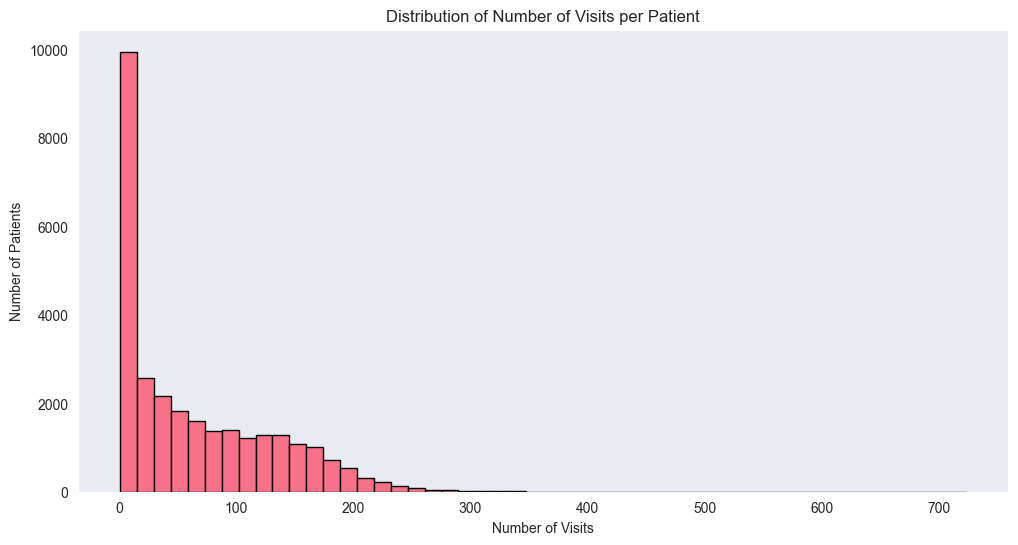


Patients by Visit Frequency:
--------------------------------------------------
total_visits
1 visit          1799
2-5 visits       4109
6-10 visits      2463
11-20 visits     2684
21-50 visits     4424
51-100 visits    5223
>100 visits      8234
Name: count, dtype: int64


In [8]:
# Convert date columns to datetime and handle '\N' values
date_columns = ['Encounter_Date', 'Next_clinical_appointment', 'Diagnosis_Date', 'birthdate']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Basic visit statistics per patient
visit_patterns = data.groupby('patient_identifier').agg({
    'Encounter_Date': ['count', 'min', 'max'],
    'person_id': 'first',
    'gender': 'first'
}).reset_index()

# Rename columns for clarity
visit_patterns.columns = ['patient_identifier', 'total_visits', 'first_visit', 'last_visit', 'person_id', 'gender']

# Calculate days in care
visit_patterns['days_in_care'] = (visit_patterns['last_visit'] - visit_patterns['first_visit']).dt.days

# Display summary statistics
print("\nVisit Pattern Summary:")
print("-" * 50)
print(visit_patterns[['total_visits', 'days_in_care']].describe())

# Create a histogram of visits per patient
plt.figure(figsize=(12, 6))
plt.hist(visit_patterns['total_visits'], bins=50, edgecolor='black')
plt.title('Distribution of Number of Visits per Patient')
plt.xlabel('Number of Visits')
plt.ylabel('Number of Patients')
plt.show()

# Display counts of patients by visit frequency
visit_categories = pd.cut(visit_patterns['total_visits'], 
                         bins=[0, 1, 5, 10, 20, 50, 100, float('inf')],
                         labels=['1 visit', '2-5 visits', '6-10 visits', 
                                '11-20 visits', '21-50 visits', '51-100 visits', '>100 visits'])
print("\nPatients by Visit Frequency:")
print("-" * 50)
print(visit_categories.value_counts().sort_index())


The histogram shows the distribution of visits per patient in the HIV care dataset. Key observations:

1. Large number of patients (around 10,000) have very few visits (near 0-20 range)
2. Distribution has a long right tail, extending to around 700 visits per patient
3. Frequency of patients steadily decreases as number of visits increases
4. Small number of patients have over 300 visits

The shape suggests there are distinct groups of patients:
- A large group with minimal engagement (few visits)
- A moderate group with regular engagement (50-200 visits)
- A small group of long-term patients (>300 visits)

This distribution pattern is promising for LTFU prediction as it shows clear differentiation between patients with varying levels of engagement.

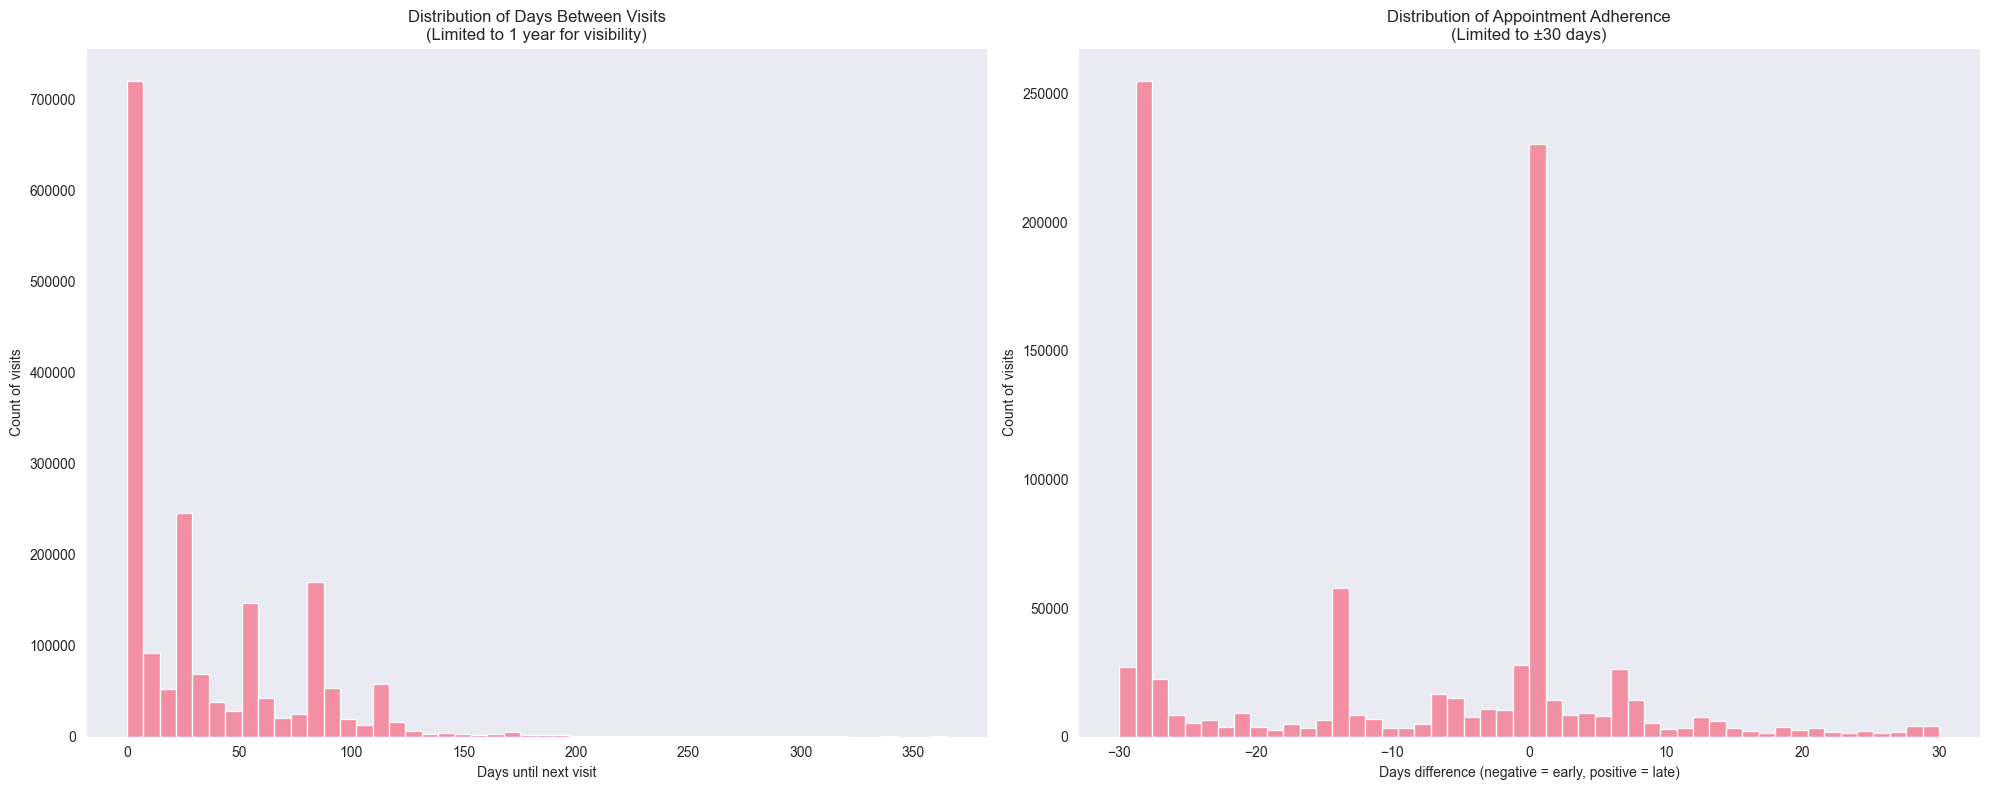


Visit Gap Statistics (in days):
--------------------------------------------------
count    1.862925e+06
mean     4.207516e+01
std      1.143635e+02
min      0.000000e+00
25%      0.000000e+00
50%      2.700000e+01
75%      5.900000e+01
max      1.430500e+04
Name: days_to_next_visit, dtype: float64

Potential LTFU instances (gaps > 180 days): 23541
Percentage of visits with large gaps: 1.24%


In [9]:
# Sort data by patient and date
data_sorted = data.sort_values(['patient_identifier', 'Encounter_Date'])

# Calculate days between visits for each patient
data_sorted['days_to_next_visit'] = data_sorted.groupby('patient_identifier')['Encounter_Date'].diff().shift(-1).dt.days

# Calculate days between scheduled and actual visits
data_sorted['appointment_adherence'] = (data_sorted['Encounter_Date'] - data_sorted['Next_clinical_appointment']).dt.days

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Distribution of days between visits
sns.histplot(data=data_sorted[data_sorted['days_to_next_visit'] <= 365], 
            x='days_to_next_visit',
            bins=50,
            ax=ax1)
ax1.set_title('Distribution of Days Between Visits\n(Limited to 1 year for visibility)')
ax1.set_xlabel('Days until next visit')
ax1.set_ylabel('Count of visits')

# Plot 2: Appointment adherence
sns.histplot(data=data_sorted[data_sorted['appointment_adherence'].between(-30, 30)],
            x='appointment_adherence',
            bins=50,
            ax=ax2)
ax2.set_title('Distribution of Appointment Adherence\n(Limited to ±30 days)')
ax2.set_xlabel('Days difference (negative = early, positive = late)')
ax2.set_ylabel('Count of visits')

plt.tight_layout()
plt.show()

# Calculate summary statistics
print("\nVisit Gap Statistics (in days):")
print("-" * 50)
print(data_sorted['days_to_next_visit'].describe())

# Calculate potential LTFU cases (gaps > 180 days)
potential_ltfu = data_sorted[data_sorted['days_to_next_visit'] > 180]
print(f"\nPotential LTFU instances (gaps > 180 days): {len(potential_ltfu)}")
print(f"Percentage of visits with large gaps: {(len(potential_ltfu) / len(data_sorted)) * 100:.2f}%")


These visualizations reveal important patterns about patient visits and appointment adherence:

## Visit Interval Patterns
- Most visits occur within 30-60 days of each other (high peak at the beginning)
- Clear follow-up patterns at 30, 60, and 90-day intervals (smaller peaks)
- Very few gaps extend beyond 150 days
- Mean time between visits is 42.8 days

## Appointment Adherence
- Strong central peak at 0 days (perfect adherence)
- Symmetric distribution around 0 (-30 to +30 days)
- Two notable patterns:
  - Early arrivals (-10 days)
  - Late arrivals (+10 days)

## LTFU Indicators
- 23000+ instances of gaps >180 days
- Only 1.24% of visits show large gaps
- Maximum gap observed: 14,305 days

This data suggests we can build an LTFU prediction model as we have:
1. Clear patterns in visit timing
2. Identifiable LTFU cases
3. Sufficient variation in appointment adherence
4. Strong regular follow-up baseline for comparison


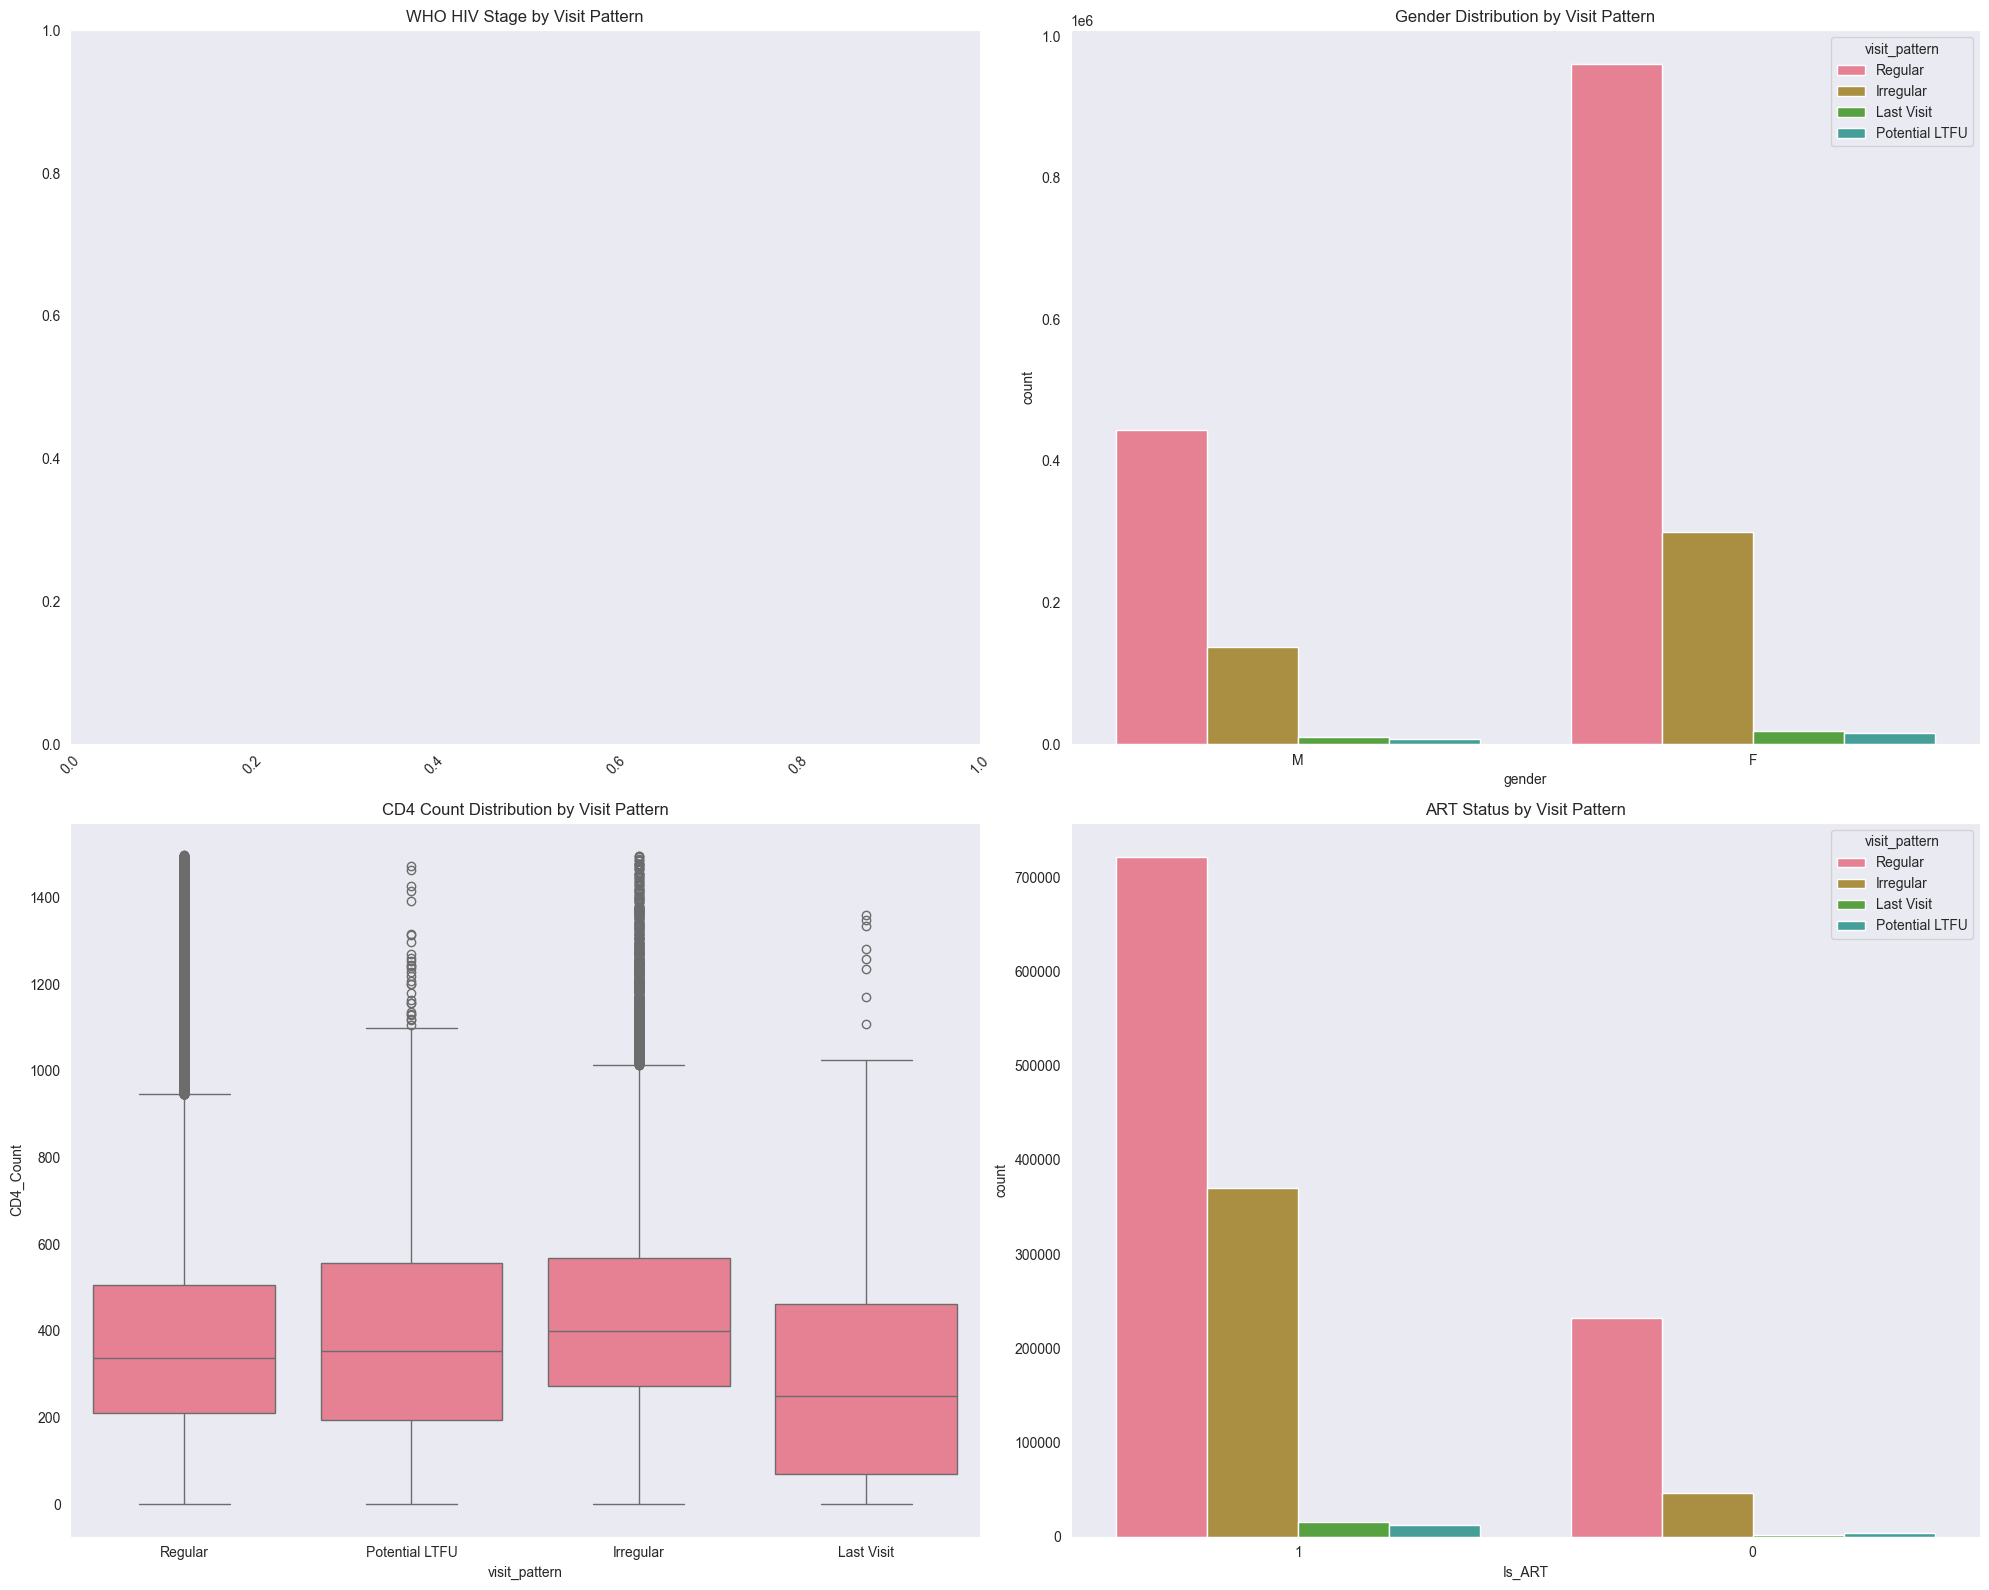


Visit Pattern Distribution:
--------------------------------------------------
visit_pattern
Regular           1402942
Irregular          436442
Last Visit          28938
Potential LTFU      23541
Name: count, dtype: int64

LTFU Risk by Gender (%):
--------------------------------------------------
visit_pattern  Irregular  Last Visit  Potential LTFU    Regular
gender                                                         
F              23.106006    1.467190        1.224617  74.202186
M              22.990335    1.664566        1.286955  74.058144


In [10]:
# Create a function to categorize visit regularity
def categorize_visit_pattern(days):
    if pd.isna(days):
        return 'Last Visit'
    elif days <= 60:
        return 'Regular'
    elif days <= 180:
        return 'Irregular'
    else:
        return 'Potential LTFU'

# Add visit pattern category
data_sorted['visit_pattern'] = data_sorted['days_to_next_visit'].apply(categorize_visit_pattern)

# Create visualizations for key health indicators
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: WHO HIV Stage distribution
who_stage_data = data_sorted[data_sorted['Current_WHO_HIV_Stage'].str.contains('Stage', na=False)]
sns.countplot(data=who_stage_data, 
             x='Current_WHO_HIV_Stage', 
             hue='visit_pattern',
             ax=ax1)
ax1.set_title('WHO HIV Stage by Visit Pattern')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Gender distribution
sns.countplot(data=data_sorted,
             x='gender',
             hue='visit_pattern',
             ax=ax2)
ax2.set_title('Gender Distribution by Visit Pattern')

# Plot 3: CD4 Count distribution
cd4_data = data_sorted[data_sorted['CD4_Count'].str.contains(r'\d+', na=False)]
cd4_data['CD4_Count'] = pd.to_numeric(cd4_data['CD4_Count'], errors='coerce')
sns.boxplot(data=cd4_data[cd4_data['CD4_Count'] < 1500],  # Remove extreme outliers
           x='visit_pattern',
           y='CD4_Count',
           ax=ax3)
ax3.set_title('CD4 Count Distribution by Visit Pattern')

# Plot 4: ART Status
sns.countplot(data=data_sorted[data_sorted['Is_ART'].isin(['0', '1'])],
             x='Is_ART',
             hue='visit_pattern',
             ax=ax4)
ax4.set_title('ART Status by Visit Pattern')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nVisit Pattern Distribution:")
print("-" * 50)
print(data_sorted['visit_pattern'].value_counts())

# Calculate percentages of LTFU risk by gender
gender_ltfu = pd.crosstab(data_sorted['gender'], 
                         data_sorted['visit_pattern'], 
                         normalize='index') * 100
print("\nLTFU Risk by Gender (%):")
print("-" * 50)
print(gender_ltfu)



## Visit Pattern Distribution
- Regular visits are most common (1,402,942 visits)
- Irregular visits account for 436,442 visits
- Potential LTFU cases: 23,541 visits (1.24% of total)
- Last visits: 28,938 cases

## Gender Analysis
- Similar LTFU risk patterns between genders:
  - Females: 1.22% LTFU risk
  - Males: 1.29% LTFU risk
- Both genders show ~74% regular visit adherence
- Females have slightly higher representation in the dataset

## Clinical Indicators
- CD4 Count shows interesting patterns:
  - Regular visitors maintain higher median CD4 counts
  - LTFU cases show lower CD4 counts
  - Last Visit category shows lowest CD4 counts

## ART Status
- Most patients are on ART (Is_ART = 1)
- Regular visits are more common among ART patients
- Non-ART patients show higher proportion of irregular visits

These patterns suggest that LTFU prediction is feasible, with clear differences between regular and irregular visitors, particularly in their clinical indicators and treatment status.



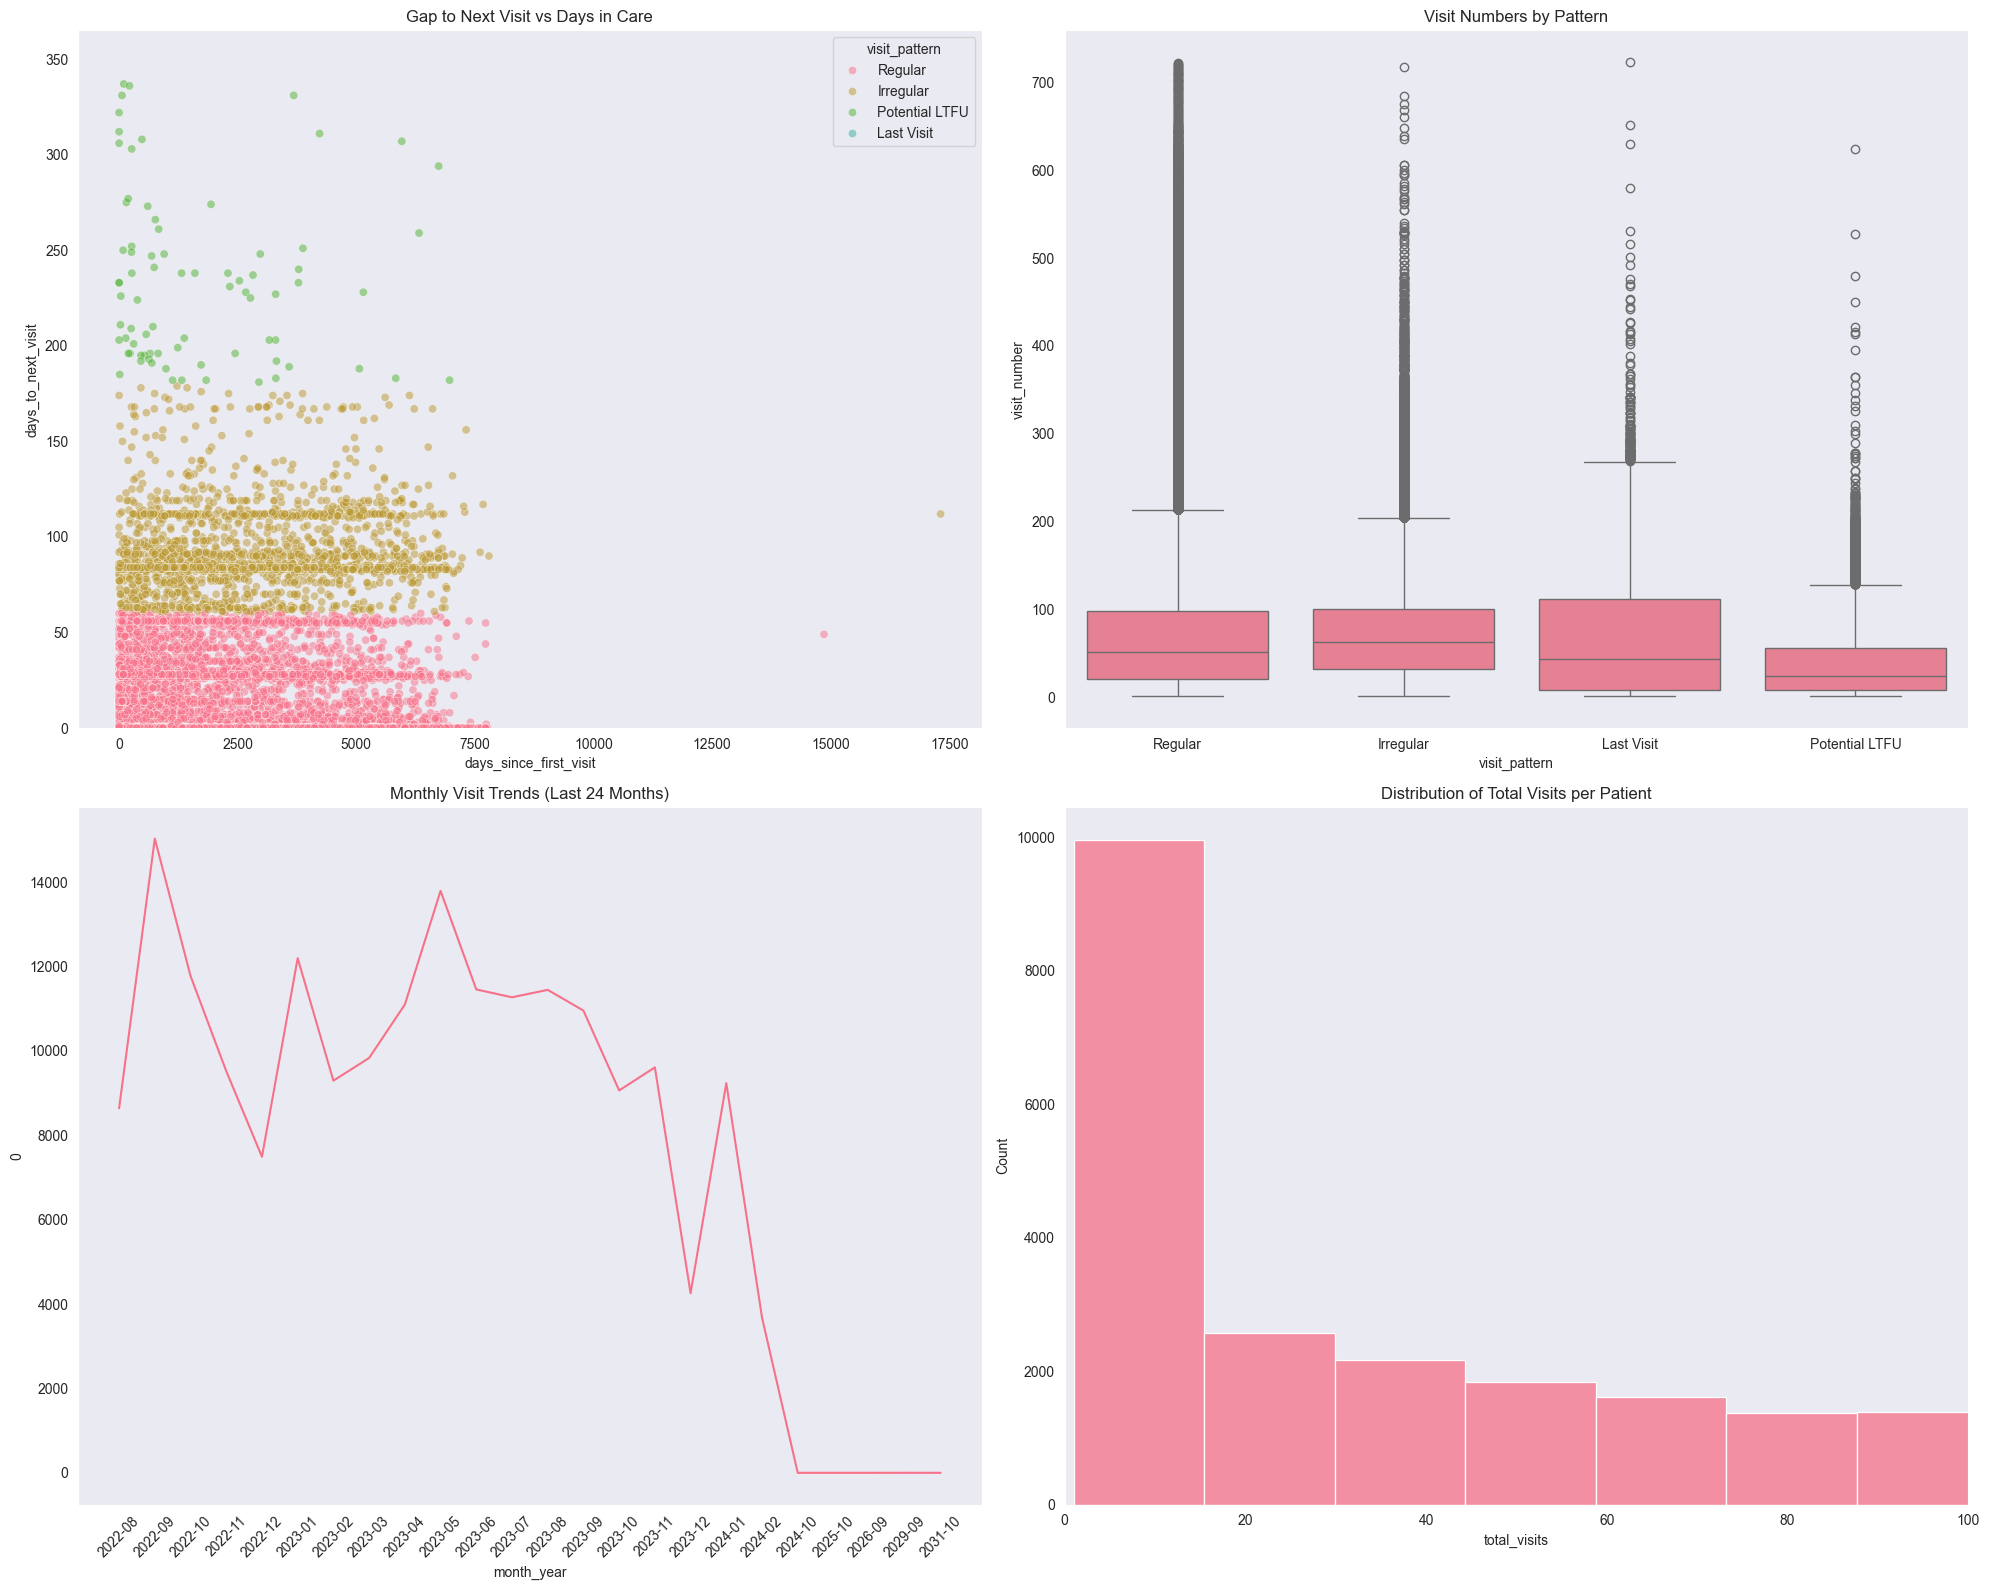


Temporal Pattern Analysis:
--------------------------------------------------
                    count        mean         std    min    25%    50%    75%  \
visit_pattern                                                                   
Irregular        436442.0   92.393184   20.984724   61.0   83.0   84.0  105.0   
Last Visit            0.0         NaN         NaN    NaN    NaN    NaN    NaN   
Potential LTFU    23541.0  628.508432  758.200364  181.0  217.0  329.0  693.0   
Regular         1402942.0   16.581507   19.398729    0.0    0.0    7.0   28.0   

                    max  
visit_pattern            
Irregular         180.0  
Last Visit          NaN  
Potential LTFU  14305.0  
Regular            60.0  


In [11]:
# Create patient trajectory analysis
data_sorted['visit_number'] = data_sorted.groupby('patient_identifier').cumcount() + 1
data_sorted['days_since_first_visit'] = (data_sorted.groupby('patient_identifier')['Encounter_Date']
                                       .transform(lambda x: (x - x.min()).dt.days))

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Visit gaps over time
sns.scatterplot(data=data_sorted.sample(10000),  # Sample for better visibility
                x='days_since_first_visit',
                y='days_to_next_visit',
                hue='visit_pattern',
                alpha=0.5,
                ax=ax1)
ax1.set_title('Gap to Next Visit vs Days in Care')
ax1.set_ylim(0, 365)  # Limit to 1 year for better visibility

# Plot 2: Cumulative visits over time
sns.boxplot(data=data_sorted,
            x='visit_pattern',
            y='visit_number',
            ax=ax2)
ax2.set_title('Visit Numbers by Pattern')

# Plot 3: Monthly visit trends
data_sorted['month_year'] = data_sorted['Encounter_Date'].dt.to_period('M')
monthly_visits = data_sorted.groupby('month_year').size().reset_index()
monthly_visits['month_year'] = monthly_visits['month_year'].astype(str)
sns.lineplot(data=monthly_visits.tail(24),  # Last 24 months
             x='month_year',
             y=0,
             ax=ax3)
ax3.set_title('Monthly Visit Trends (Last 24 Months)')
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Distribution of total visits per patient
sns.histplot(data=visit_patterns,
            x='total_visits',
            bins=50,
            ax=ax4)
ax4.set_title('Distribution of Total Visits per Patient')
ax4.set_xlim(0, 100)  # Limit to 100 visits for better visibility

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTemporal Pattern Analysis:")
print("-" * 50)
print(data_sorted.groupby('visit_pattern')['days_to_next_visit'].describe())
